# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 - pmdarima >= 1.3.0
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os
os.environ['KERAS_BACKEND'] = 'theano'
#export THEANO_FLAGS=blas.ldflags="-L${MKLROOT}/lib/intel64 -lmkl_rt -lpthread -lm -ldl"
#os.environ['THEANO_FLAGS'] = blas.ldflags="-L/usr/lib64/atlas/ -lptf77blas -lptcblas -latlas"' #'blas.ldflags="-L/usr/lib64/ -lblas"'#'blas.ldflags="-L/usr/lib64/ -lf77blas -latlas -lgfortran"' #"-L/usr/local/lib/ -lblas"'

from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, GaussianNoise, GaussianDropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid") # whitegrid
sns.set_context("notebook") # paper
if not os.path.exists('historicos_naive_uni'):
    os.makedirs('historicos_naive_uni')
if not os.path.exists('modelos_naive_uni'):
    os.makedirs('modelos_naive_uni')

Using Theano backend.


Definição de constantes:

In [3]:
janela = 12 # 2, 3, 4, 6, 8, 12
adicional_reco = 60 # 12, 24, 48, 72, 96
teste = 120
fracao_valida = 0.2

Funções auxiliadoras para o cálculo de métricas, demonstração gráficas e montagem das matrizes

In [4]:
indices_teste_seco = [k for k in range(-teste,0) if k%-12 in [-8,-7,-6,-5,-4,-3]]
indices_teste_umido = [k for k in range(-teste,0) if k%-12 in [0,-11,-10,-9,-2,-1]]

def imprime_metricas(real, predito, fator_normalizacao, teste=False):
    print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('MSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao**2 , end=', ')
    print('MAPE = ', 100*np.mean(np.abs(predito-real)/real), '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*fator_normalizacao , end=', ')
    print('R = ', metrics.r2_score(real, predito))
    if teste:
        ps = predito[indices_teste_seco]
        rs = real[indices_teste_seco]
        pu = predito[indices_teste_umido]
        ru = real[indices_teste_umido]
        print('MAPE seco = ', 100*np.mean(np.abs(ps-rs)/rs), '%')
        print('MAPE umido = ', 100*np.mean(np.abs(pu-ru)/ru), '%')

def mostra_treinamento(historico, init=16):
    plt.plot(historico['loss'][init:])
    plt.plot(historico['val_loss'][init:])
    plt.ylabel('Erro Relativo Médio')
    plt.xlabel('Iterações')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.show()

def mostra_performance(modelo, entrada, saida, fator_normalizacao, teste=False):
    predito = modelo.predict(entrada)
    plt.plot(saida, '-o')
    plt.plot(predito, '-o')
    plt.legend(['Real', 'Predito'], loc='upper right')
    if teste:
        plt.xticks(np.arange(0, len(saida)+1, step=12), ['dez/%02d'%(k+1) for k in range(12)])
    else:
        plt.xticks(np.arange(0, len(saida)+1, step=12))
    plt.show()
    imprime_metricas(saida, predito, fator_normalizacao, teste)

def salva_historico(historico, nome_arquivo):
    arquivo = open(nome_arquivo, 'wb')
    pickle.dump(historico, arquivo)
    arquivo.close()

def carrega_historico(nome_arquivo):
    try:
        arquivo = open(nome_arquivo, 'rb')
        historico = pickle.load(arquivo)
        arquivo.close()
    except:
        return False
    return historico

def separa_serie(serie, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela))
    for i in range(tam):
        x_separado[i, :] = serie[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 1))
    y_separado[:, 0] = serie[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def separa_serie_reco(serie, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela, 1))
    for i in range(tam):
        x_separado[i, :, 0] = serie[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 1))
    y_separado[:, 0] = serie[inicio_y:inicio_y+tam]
    return x_separado, y_separado

Carregamento incial dos dados

In [5]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
valida = int((len(furnas) - teste - janela) * fracao_valida)
treino = len(furnas) - teste - valida - janela
fator_normalizacao = furnas[:treino].max()
furnas /= fator_normalizacao

x_treina, y_treina = separa_serie(furnas, janela, janela, treino)
x_valida, y_valida = separa_serie(furnas, janela, janela+treino, valida)
x_teste, y_teste = separa_serie(furnas, janela, janela+treino+valida, teste)

assert(x_treina[31, -1] == y_treina[30, -1])
print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  682
Validação,  170
Teste,  120
Total,  972


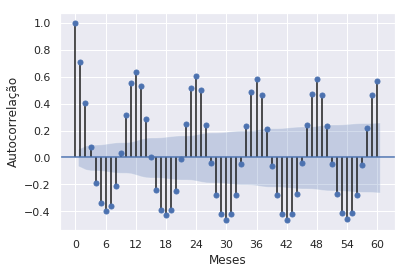

In [6]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()
plt.rcParams["figure.figsize"] = (15, 10)

# Um único neurônio (regressão linear)

sigma_ruido = sqrt(rate / (1 - rate))

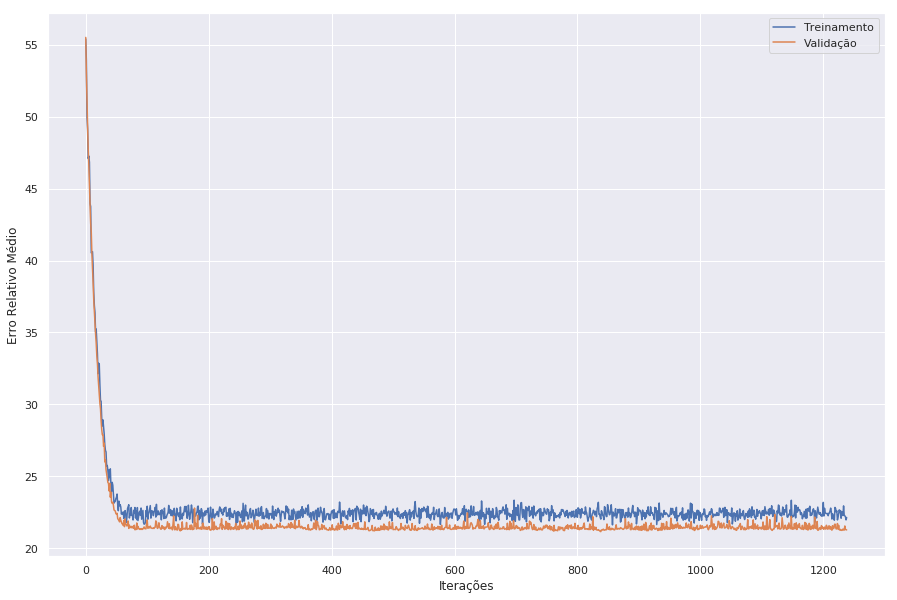

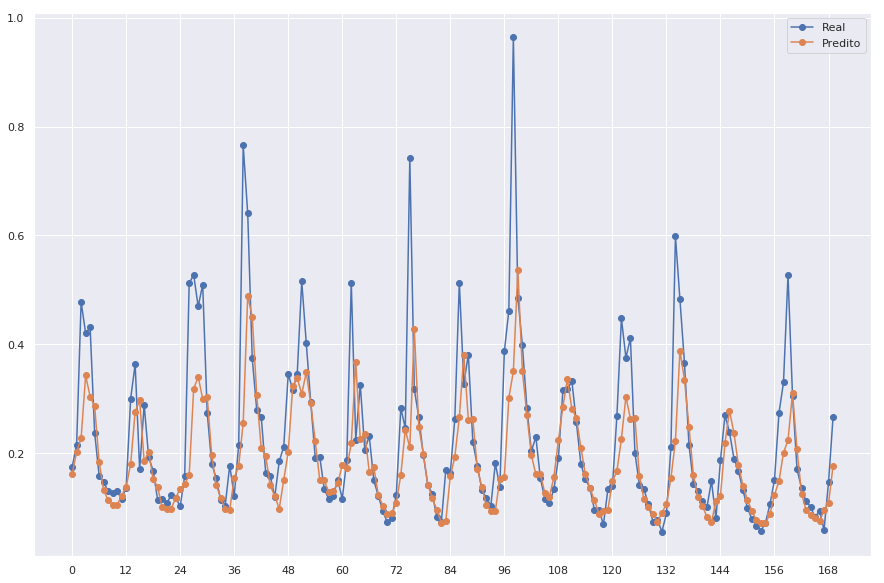

RMSE =  425.02754178650116, MSE =  180648.41127707597, MAPE =  21.164938898096437 %, MAE =  229.7791526799693, R =  0.4412342298060199


In [7]:
def modelo_uno(janela, ruido=0.02):
    entrada = Input(shape=(janela,))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    estimativa = Dense(1, activation='tanh')(entrada_ruidosa)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive_uni/melhor_uno.h5'):
    uno = modelo_uno(janela)
    uno.compile(optimizer='adam', loss='mape')
    parar_uno = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0)
    salvar_uno = ModelCheckpoint('modelos_naive_uni/melhor_uno.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_uno = uno.fit(x_treina, y_treina, epochs=10000, validation_data=(x_valida, y_valida), verbose=0, callbacks=[parar_uno, salvar_uno])
    salva_historico(historico_uno.history, 'historicos_naive_uni/uno')

mostra_treinamento(carrega_historico('historicos_naive_uni/uno'))
uno = load_model('modelos_naive_uni/melhor_uno.h5')
mostra_performance(uno, x_valida, y_valida, fator_normalizacao)

# Multilayer perceptron

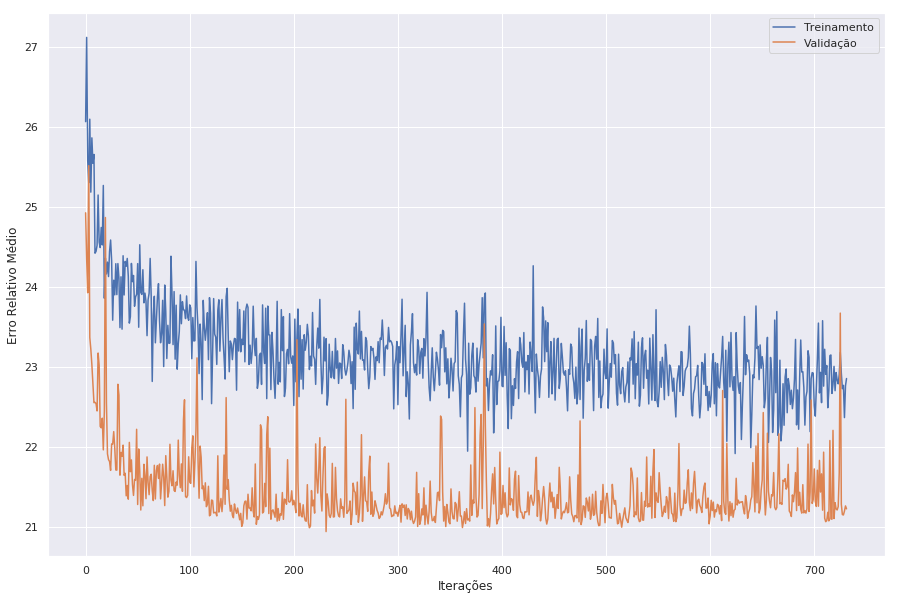

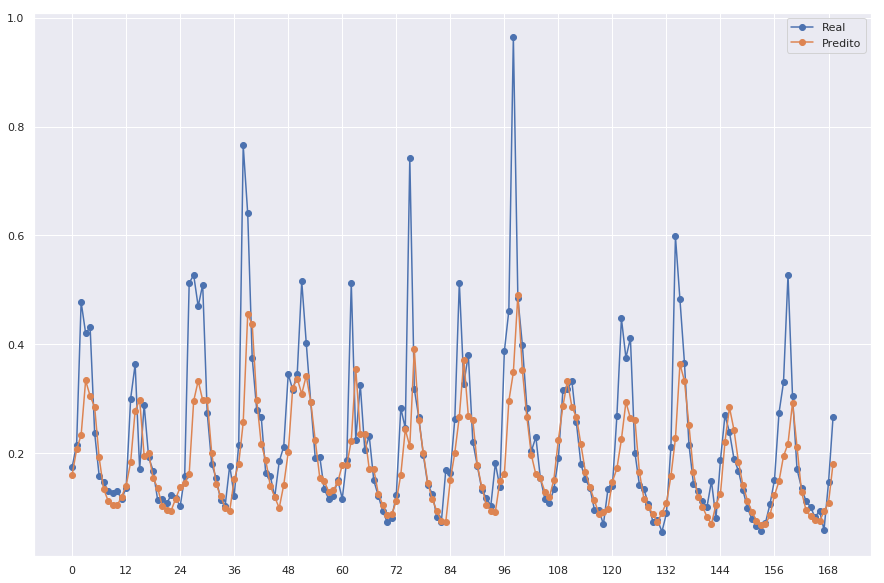

RMSE =  425.3012923723346, MSE =  180881.18929357803, MAPE =  20.939342531505243 %, MAE =  228.0867830105564, R =  0.44051422132791873


In [8]:
def modelo_mlp(janela, ruido=0.03):
    entrada = Input(shape=(janela,))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.001))(entrada_ruidosa)
    X = Dense(6, activation='tanh')(entrada_ruidosa)
    X = GaussianDropout(0.003)(X)
    X = Dense(3, activation='tanh')(X)
    X = GaussianDropout(0.001)(X)
    estimativa = Dense(1)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive_uni/melhor_mlp.h5'):
    mlp = modelo_mlp(janela)
    mlp.compile(optimizer='adam', loss='mape')
    parar_mlp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_mlp = ModelCheckpoint('modelos_naive_uni/melhor_mlp.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_mlp = mlp.fit(x_treina, y_treina, epochs=10000, validation_data=(x_valida, y_valida), verbose=0, callbacks=[parar_mlp, salvar_mlp])
    salva_historico(historico_mlp.history, 'historicos_naive_uni/mlp')

mostra_treinamento(carrega_historico('historicos_naive_uni/mlp'))
mlp = load_model('modelos_naive_uni/melhor_mlp.h5')
mostra_performance(mlp, x_valida, y_valida, fator_normalizacao)

## Divisão do conjuntos de dados para redes recorrentes

Para o treinamento de redes recorrentes no Keras é necessário escrever um tensor de ordem 3

In [9]:
janela_reco = janela + adicional_reco
valida_reco = int((len(furnas) - teste - janela_reco) * fracao_valida)
treino_reco = len(furnas) - teste - valida_reco - janela_reco

x_treina_reco, y_treina_reco = separa_serie_reco(furnas, janela_reco, janela_reco, treino_reco)
x_valida_reco, y_valida_reco = separa_serie_reco(furnas, janela_reco, janela_reco+treino_reco, valida_reco)
x_teste_reco, y_teste_reco = separa_serie_reco(furnas, janela_reco, janela_reco+treino_reco+valida_reco, teste)

assert(x_treina_reco[31, -1, -1] == y_treina_reco[30, -1])
print('Treino, ', treino_reco)
print('Validação, ', valida_reco)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela_reco)

Treino,  634
Validação,  158
Teste,  120
Total,  912


## Rede Recorrente Simples

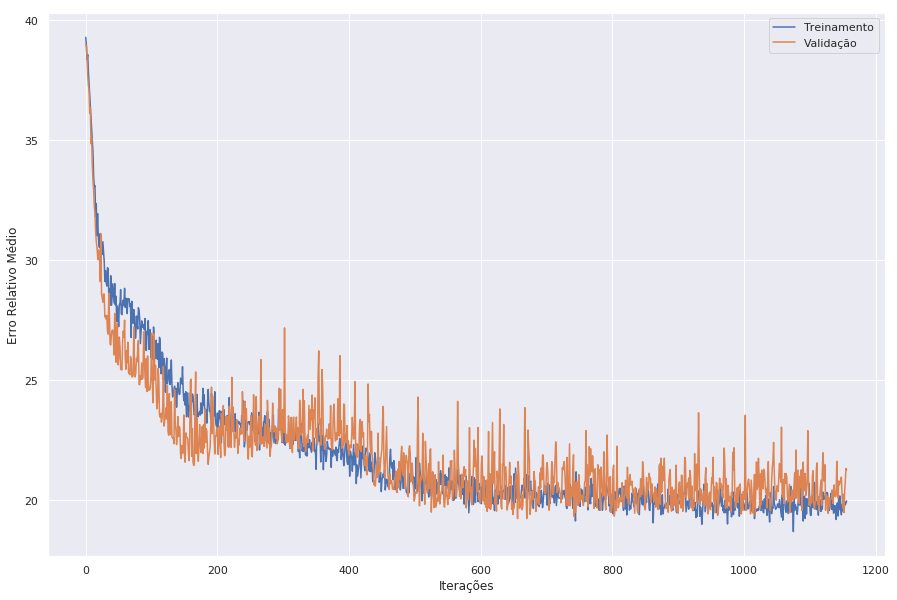

/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


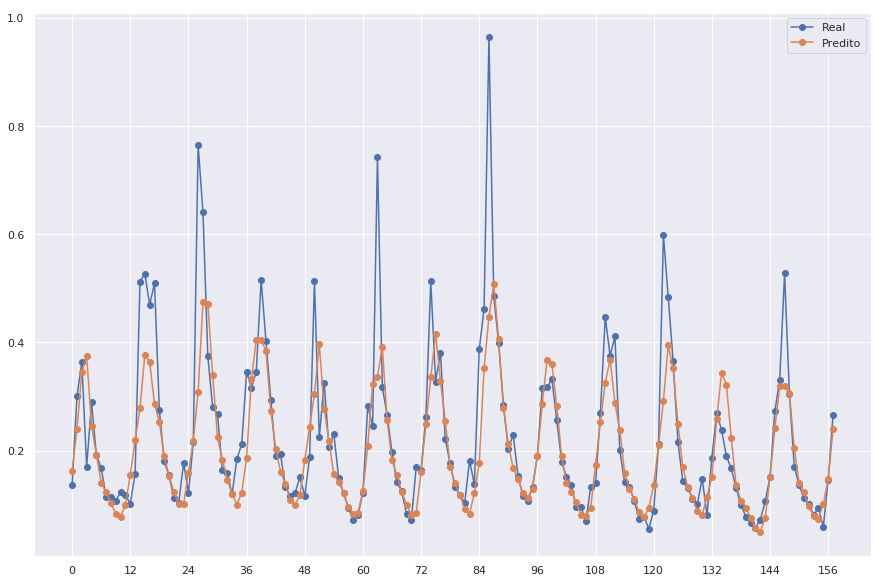

RMSE =  355.4081126602412, MSE =  126314.92654471473, MAPE =  19.212637126398224 %, MAE =  191.13266286013433, R =  0.6174821564160057


<IPython.core.display.Javascript object>

In [10]:
def modelo_reco(janela, ruido=0.05):
    entrada = Input(shape=(janela,1))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(7, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(entrada_ruidosa)
    X = GaussianDropout(0.004)(X)
    X = SimpleRNN(5)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(2, activation='tanh')(X)
    estimativa = Dense(1)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive_uni/melhor_reco.h5'):
    reco = modelo_reco(janela_reco)
    reco.compile(optimizer='adam', loss='mape')
    parar_reco = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_reco = ModelCheckpoint('modelos_naive_uni/melhor_reco.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_reco = reco.fit(x_treina_reco, y_treina_reco, epochs=10000, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_reco, salvar_reco])
    salva_historico(historico_reco.history, 'historicos_naive_uni/reco')

mostra_treinamento(carrega_historico('historicos_naive_uni/reco'))
reco = load_model('modelos_naive_uni/melhor_reco.h5')
mostra_performance(reco, x_valida_reco, y_valida_reco, fator_normalizacao)

# LSTM

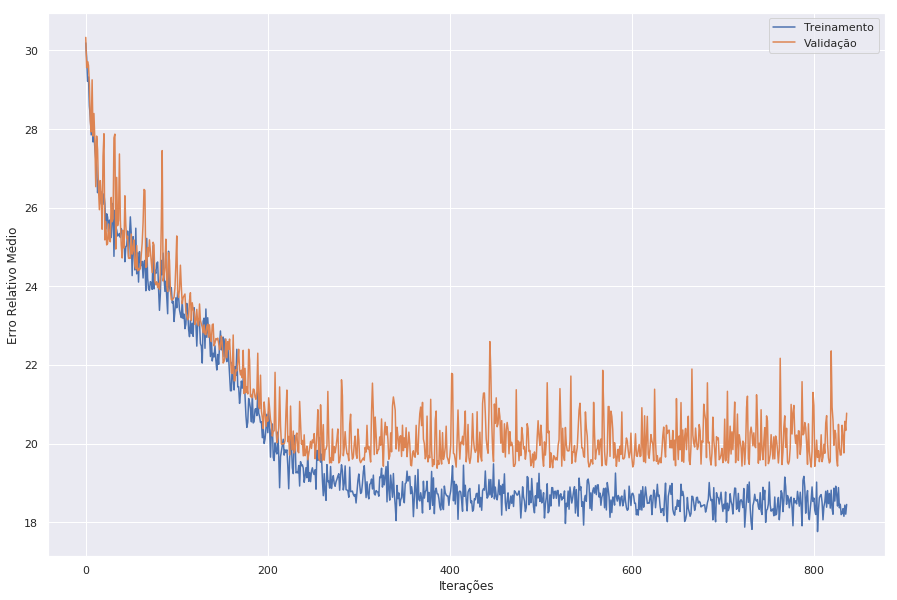

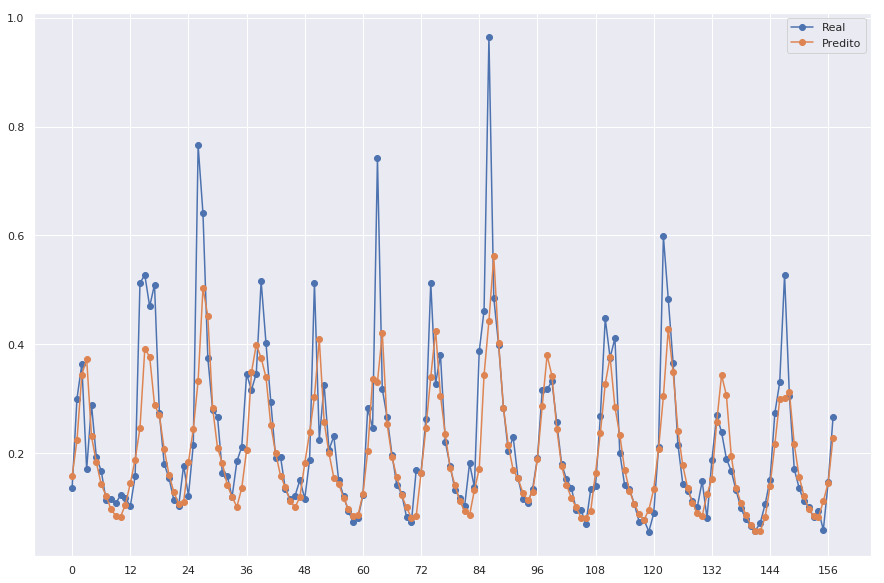

RMSE =  356.3203884763396, MSE =  126964.21924392956, MAPE =  19.37203172277956 %, MAE =  194.1729647878416, R =  0.6155159118085596


In [11]:
def modelo_lstm(janela, ruido=0.02):
    entrada = Input(shape=(janela, 1))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(12, activation='tanh')(entrada_ruidosa)
    X = GaussianDropout(0.006)(X)
    X = LSTM(5)(entrada_ruidosa)
    X = GaussianDropout(0.002)(X)
    X = Dense(3, activation='tanh')(X)
    estimativa = Dense(1)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive_uni/melhor_lstm.h5'):
    lstm = modelo_lstm(janela_reco)
    lstm.compile(optimizer='adam', loss='mape')
    parar_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=450, min_delta=0, restore_best_weights=True)
    salvar_lstm = ModelCheckpoint('modelos_naive_uni/melhor_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_lstm = lstm.fit(x_treina_reco, y_treina_reco, epochs=7500, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_lstm, salvar_lstm])
    salva_historico(historico_lstm.history, 'historicos_naive_uni/lstm')

mostra_treinamento(carrega_historico('historicos_naive_uni/lstm'))
lstm = load_model('modelos_naive_uni/melhor_lstm.h5')
mostra_performance(lstm, x_valida_reco, y_valida_reco, fator_normalizacao)

## GRU

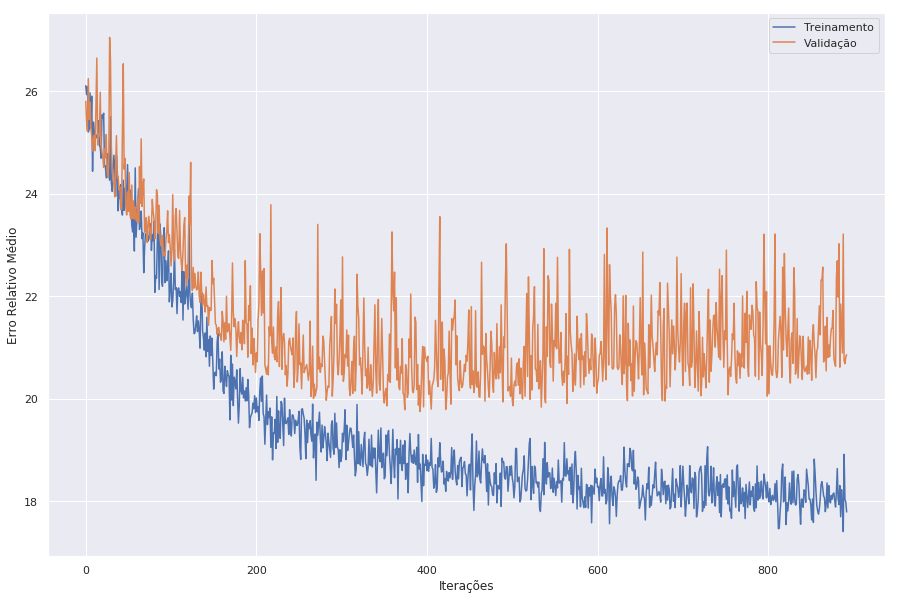

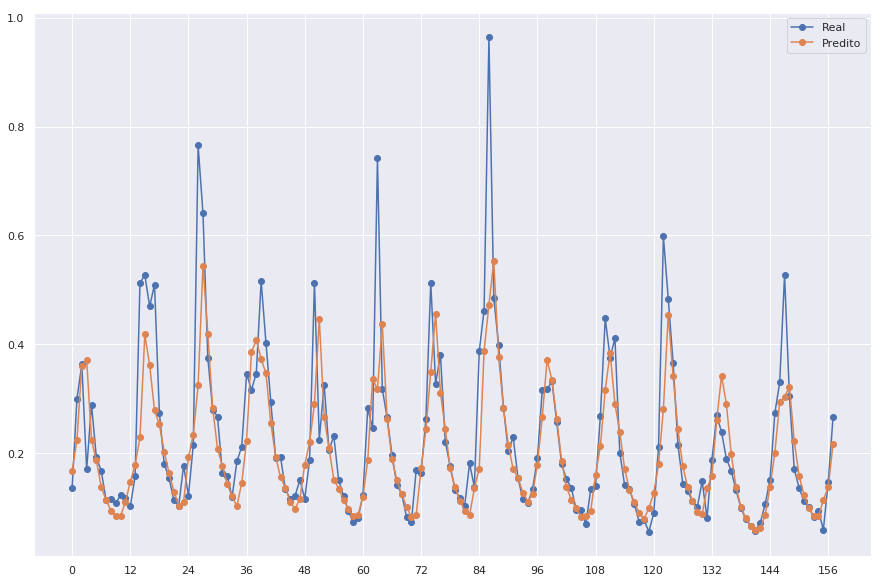

RMSE =  359.0802733766887, MSE =  128938.64272827747, MAPE =  19.702993359307442 %, MAE =  196.45352704405693, R =  0.6095367909380978


In [12]:
def modelo_gru(janela, ruido=0.02):
    entrada = Input(shape=(janela, 1))
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.02))(entrada_ruidosa)
    X = GaussianDropout(0.004)(X)
    X = GRU(6)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(3, activation='tanh')(X)
    estimativa = Dense(1)(X)
    
    modelo = Model(inputs=entrada, outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_naive_uni/melhor_gru.h5'):
    gru = modelo_gru(janela_reco)
    gru.compile(optimizer='adam', loss='mape')
    parar_gru = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_gru = ModelCheckpoint('modelos_naive_uni/melhor_gru.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_gru = gru.fit(x_treina_reco, y_treina_reco, epochs=2000, validation_data=(x_valida_reco, y_valida_reco), verbose=0, callbacks=[parar_gru, salvar_gru])
    salva_historico(historico_gru.history, 'historicos_naive_uni/gru')

mostra_treinamento(carrega_historico('historicos_naive_uni/gru'))
gru = load_model('modelos_naive_uni/melhor_gru.h5')
mostra_performance(gru, x_valida_reco, y_valida_reco, fator_normalizacao)

## Teste dos modelos

Essas avaliações devem ser executados somente após a escolha definitiva dos modelos, para que os hiperparâmetros não se tornem enviesados ao conjunto de teste.

Único Neurônio


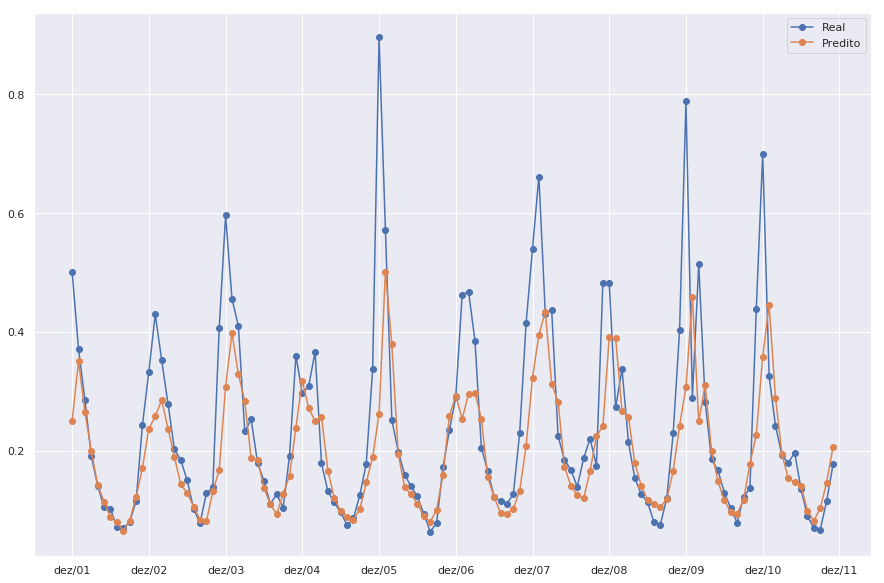

RMSE =  445.368198838697, MSE =  198352.83253682518, MAPE =  21.4699912753339 %, MAE =  253.02908060066406, R =  0.4700020897213747
MAPE seco =  14.643220944195606 %
MAPE umido =  28.296761606472188 %



MLP


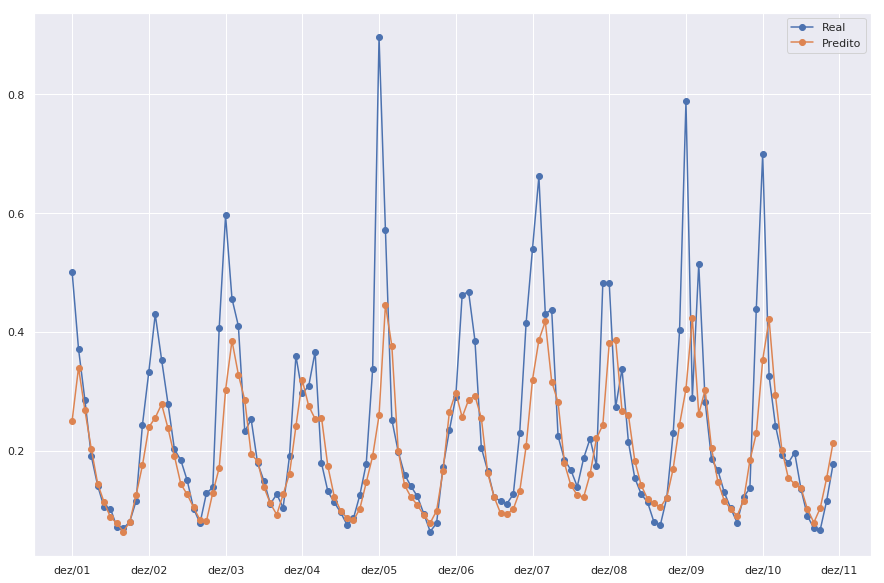

RMSE =  446.55332507550946, MSE =  199409.87213599365, MAPE =  21.47064972127623 %, MAE =  254.67692506282282, R =  0.46717768448613806
MAPE seco =  14.432253678531767 %
MAPE umido =  28.5090457640207 %



Recorrente Simples


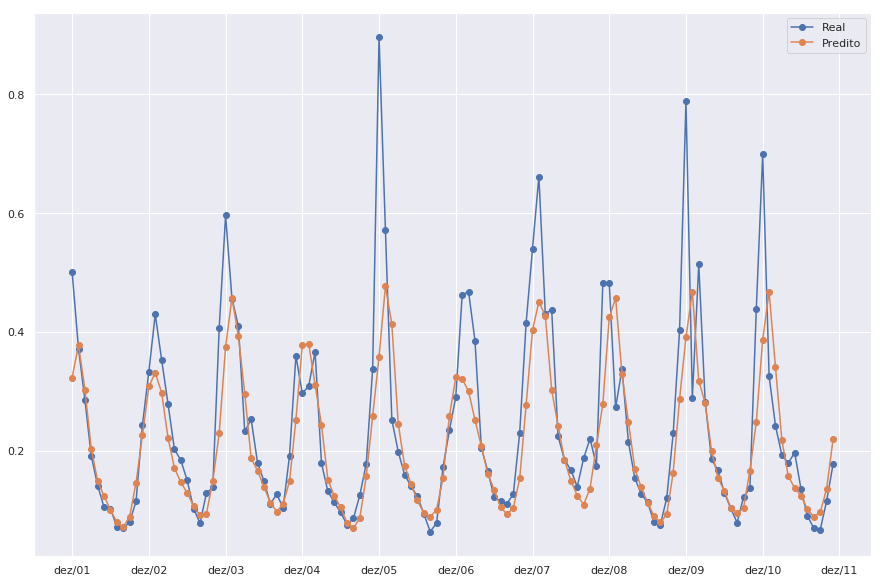

RMSE =  376.25343112130423, MSE =  141566.64443055404, MAPE =  19.46086992298757 %, MAE =  217.97278719376774, R =  0.6217345386311983
MAPE seco =  13.449500192129449 %
MAPE umido =  25.47223965384569 %



LSTM


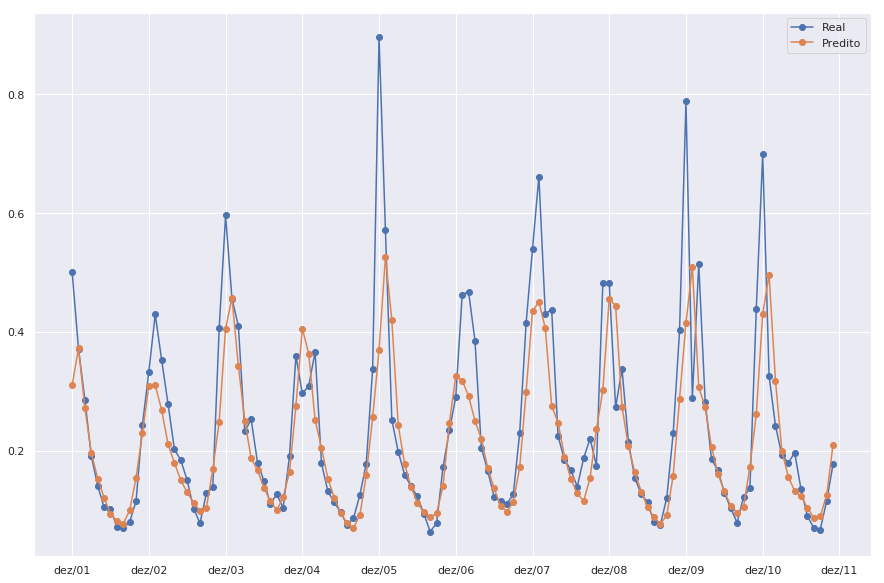

RMSE =  367.2309207120813, MSE =  134858.54912704293, MAPE =  19.266065268703645 %, MAE =  214.67292220176512, R =  0.6396585402566891
MAPE seco =  13.375848388925357 %
MAPE umido =  25.156282148481928 %



GRU


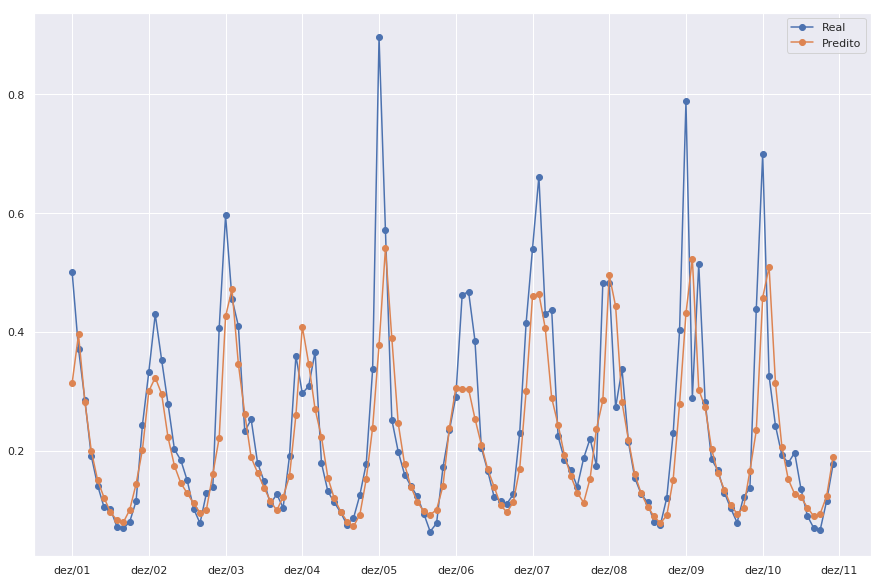

RMSE =  362.1654127951838, MSE =  131163.78622510587, MAPE =  19.363113845104316 %, MAE =  212.55499545602754, R =  0.6495309307436667
MAPE seco =  13.937354997804935 %
MAPE umido =  24.788872692403704 %


In [13]:
executar_testes = True  # Agora que todos os modelos foram definidos, execute a avaliação

if executar_testes:
    print('Único Neurônio')
    mostra_performance(uno, x_teste, y_teste, fator_normalizacao, teste=True)
    print('\n\n\nMLP')
    mostra_performance(mlp, x_teste, y_teste, fator_normalizacao, teste=True)
    print('\n\n\nRecorrente Simples')
    mostra_performance(reco, x_teste_reco, y_teste_reco, fator_normalizacao, teste=True)
    print('\n\n\nLSTM')
    mostra_performance(lstm, x_teste_reco, y_teste_reco, fator_normalizacao, teste=True)
    print('\n\n\nGRU')
    mostra_performance(gru , x_teste_reco, y_teste_reco, fator_normalizacao, teste=True)